<a href="https://colab.research.google.com/github/TatKhachatryan/Classification-Project/blob/main/Mobile_Price_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# !pip install -q condacolab
# import condacolab
# condacolab.install()

In [6]:
# !conda install -c conda-forge python-kaleido

In [7]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

In [8]:
train = pd.read_csv('/content/drive/MyDrive/Mobile Price Classification/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Mobile Price Classification/test.csv')

print("Train Size: ", train.shape)
print("Test Size: ", test.shape)

Train Size:  (2000, 21)
Test Size:  (1000, 21)


Dataset columns are as follows:

* **id** - ID
* **battery_power** - Total energy a battery can store in one time measured in mAh (milliampere hour - is 1000th of an ampere hour ( Ah ))
* **blue** - Has bluetooth or not
* **clock_speed** - Speed at which microprocessor executes instructions
* **dual_sim** - Has dual sim support or not
* **fc** - Front Camera mega pixels
* **four_g** - Has 4G or not
* **int_memory** - Internal Memory in Gigabytes
* **m_dep** - Mobile Depth in cm
* **mobile_wt** - Weight of mobile phone
* **n_cores** - Number of cores of processor
* **pc** - Primary Camera mega pixels
* **px_height** - Pixel Resolution Height
* **px_width** - Pixel Resolution Width
* **ram** - Random Access Memory in Megabytes
* **sc_h** - Screen Height of mobile in cm
* **sc_w** - Screen Width of mobile in cm
* **talk_time** - Longest time that a single battery charge will last when you are
* **three_g** - Has 3G or not
* **touch_screen** - Has touch screen or not
* **wifi** - Has wifi or not
* **price_range** - This is the target variable with value of:
** 0 (low cost)
** 1 (medium cost)
** 2 (high cost)
** 3 (very high cost)

# EDA

In [9]:
train['price_range'].unique()

array([1, 2, 3, 0])

So we have a multi-class classification problem.

Machine learning algorithm for multiclass classification:
* Decision Trees,
* k-Nearest Neighbors,
* Naive Bayes
* Support Vector Machine 

In [10]:
train.describe()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
count,2000.000000,2000.0000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,1238.518500,0.4950,1.522250,0.509500,4.309500,0.521500,32.046500,0.501750,140.249000,4.520500,9.916500,645.108000,1251.515500,2124.213000,12.306500,5.767000,11.011000,0.761500,0.503000,0.507000,1.500000
std,439.418206,0.5001,0.816004,0.500035,4.341444,0.499662,18.145715,0.288416,35.399655,2.287837,6.064315,443.780811,432.199447,1084.732044,4.213245,4.356398,5.463955,0.426273,0.500116,0.500076,1.118314
min,501.000000,0.0000,0.500000,0.000000,0.000000,0.000000,2.000000,0.100000,80.000000,1.000000,0.000000,0.000000,500.000000,256.000000,5.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000
25%,851.750000,0.0000,0.700000,0.000000,1.000000,0.000000,16.000000,0.200000,109.000000,3.000000,5.000000,282.750000,874.750000,1207.500000,9.000000,2.000000,6.000000,1.000000,0.000000,0.000000,0.750000
50%,1226.000000,0.0000,1.500000,1.000000,3.000000,1.000000,32.000000,0.500000,141.000000,4.000000,10.000000,564.000000,1247.000000,2146.500000,12.000000,5.000000,11.000000,1.000000,1.000000,1.000000,1.500000
75%,1615.250000,1.0000,2.200000,1.000000,7.000000,1.000000,48.000000,0.800000,170.000000,7.000000,15.000000,947.250000,1633.000000,3064.500000,16.000000,9.000000,16.000000,1.000000,1.000000,1.000000,2.250000
max,1998.000000,1.0000,3.000000,1.000000,19.000000,1.000000,64.000000,1.000000,200.000000,8.000000,20.000000,1960.000000,1998.000000,3998.000000,19.000000,18.000000,20.000000,1.000000,1.000000,1.000000,3.000000


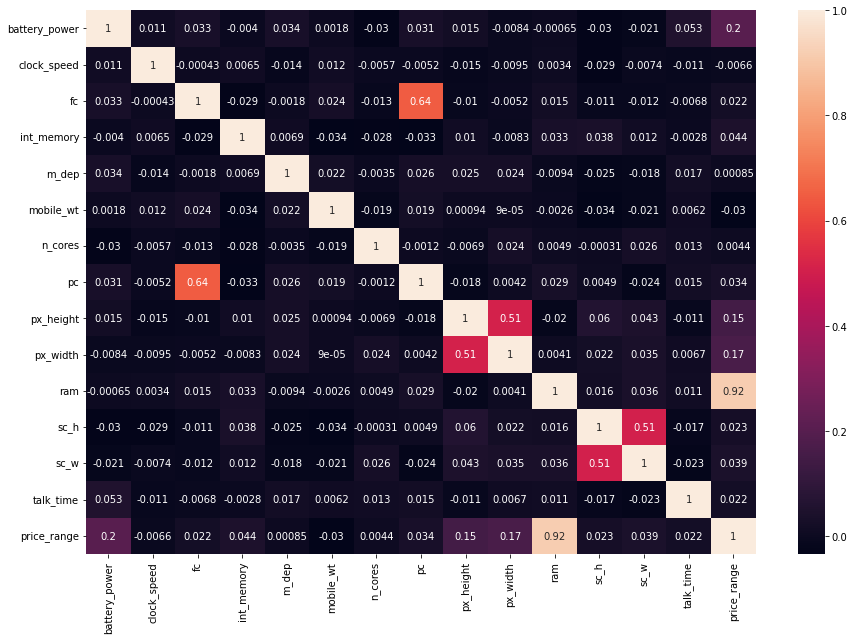

In [11]:
plt.figure(figsize = (15,10))

corr = train[['battery_power', 'clock_speed', 'fc',  'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 
               'px_height', 'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 'price_range']].corr()
sns.heatmap(corr, annot=True)
plt.show()

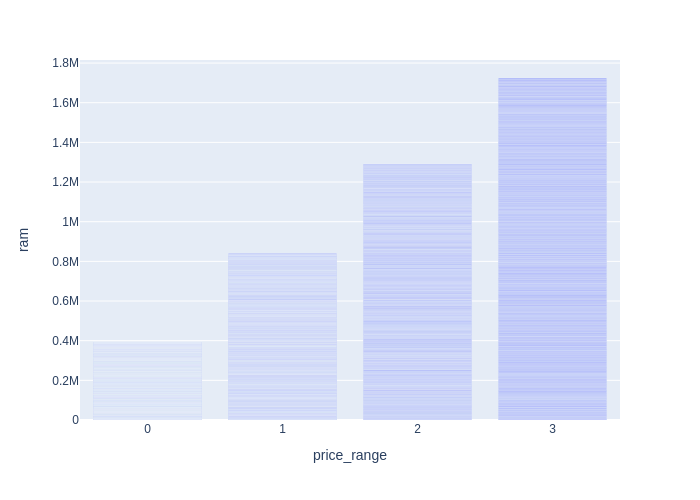

In [12]:
fig = px.bar(train, x='price_range', y='ram')
fig.show(renderer="png")